In [1]:
import sys
import os

current_directory = os.getcwd()        
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from spektral.layers import GCNConv

from postprocess.threshold import flood_threshold, drought_threshold
from preprocess.BaselinePrerocess import baseline_process, baseline_process_for_gate_predictor
from preprocess.GraphTransformerPrerocess import graph_water_transformer_cov_process_for_gate_predictor
from preprocess.graph import graph_topology_5

import pygad
import time

2023-08-07 12:00:53.666389: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-07 12:00:55.197501: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

### Preprocess

In [4]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5

In [5]:
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_gate_pump_y, val_gate_pump_y, test_gate_pump_y, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler, gate_scalar = graph_water_transformer_cov_process_for_gate_predictor(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
train_tws/val_tws/test_tws: (77069, 5, 72) (9634, 5, 72) (19268, 5, 72) 
 train_cov/val_cov/test_cov: (77069, 96, 12) (9634, 96, 12) (19268, 96, 12) 
 train_ws_y/val_ws_y/test_ws_y: (77069, 96) (9634, 96) (19268, 96) 
  train_gate_pump_y/val_gate_pump_y/test_gate_pump_y: (77069, 24, 7) (9634, 24, 7) (19268, 24, 7)


In [6]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


### Select event

In [7]:
start_idx = 9200+250
end_idx = 9200+300
duration = end_idx - start_idx

In [8]:
ws1 = test_ws_y[start_idx:end_idx, :]
ws1 = ws_scaler.inverse_transform(ws1)
ws1.shape

(50, 96)

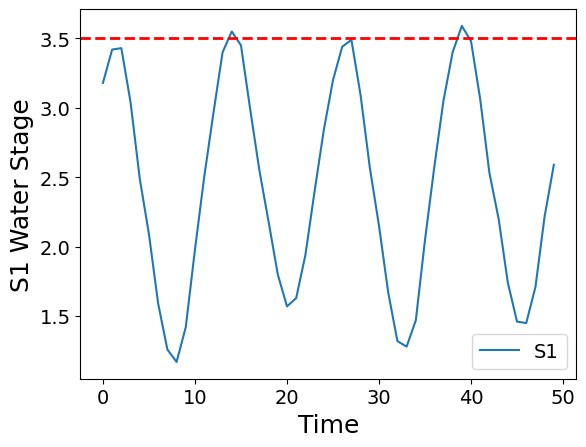

In [9]:
plt.plot(ws1[:, 0], label='S1')
plt.axhline(y = 3.5, color='r', linestyle='dashed', linewidth=2)
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

### Get optimizable and not optimizable variables

In [10]:
# X = test_X_mask[start_idx:end_idx, :, :]
# X_1d = np.reshape(X, -1)

# print(X.shape)
# print(X_1d.shape)

In [11]:
# optimizable
gate_state = test_cov[start_idx:end_idx, :, 2:9]
gate_state_1d = np.reshape(gate_state, -1)

print(gate_state.shape)
print(gate_state_1d.shape)

(50, 96, 7)
(33600,)


In [12]:
# not optimizable
not_gate1 = test_cov[start_idx:end_idx, :, 0:2]

print(not_gate1.shape)

(50, 96, 2)


In [13]:
# not optimizable
not_gate2 = test_cov[start_idx:end_idx, :, 9:]

print(not_gate2.shape)

(50, 96, 3)


### GA

In [14]:
saved_model = load_model('../saved_models/WaLeF_gtn_p.h5', custom_objects={'GCNConv': GCNConv})
# load_model('cnn.h5', compile=False)

2023-08-07 12:01:05.616176: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1


In [15]:
def fitness_func(ga_instance, solution, solution_idx):
    # ================ gate penalty ================
    solution = np.reshape(solution, (duration, 96*7))
    gate_max = 1
    gate_min = 0
    
    gate_penalty_sum = 0
    for i in range(duration):
        for j in range(96*7):
            if (solution[i, j] > gate_max):
                penalty_gate = np.abs(solution[i, j] - gate_max)**2
            elif (solution[i, j] < gate_min):
                penalty_gate = np.abs(solution[i, j] - gate_min)**2
            else:
                penalty_gate = 0
            gate_penalty_sum += penalty_gate

    # ================ get input numpy of gate ================
    solution = np.reshape(solution, (duration, 96, 7))
    input_np = np.zeros(((duration, 96, 12)))
    input_np[:, :, 0:2] = not_gate1
    input_np[:, :, 2:9] = solution
    input_np[:, :, 9:] = not_gate2
    
    # ================ predict ws ================
    yhat = saved_model.predict([input_np, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
    #yhat = saved_model.predict(input_np, verbose=0)
    
    
    # ================ ws penalty ================
    y_max = 0.62
    y_min = 0.2
    
#     ws_penalty_sum = 0
#     for i in range (duration):
#         for j in range (96):
#             if (yhat[i, j] > y_max):
#                 penalty_ws = np.abs(yhat[i, j] - y_max) + 20*np.abs(yhat[i, j] - y_max)**2
#             elif (yhat[i, j] < y_min):
#                 penalty_ws = np.abs(y_min - yhat[i, j])
                
#             else:
#                 penalty_ws = 0
            
#             ws_penalty_sum += penalty_ws
    
    # ================ gate penalty + ws penalty ================
    penalty_gate_ws_sum = 0.2*gate_penalty_sum + 2.0*ws_penalty_sum
    
    if penalty_gate_ws_sum == 0:
        fitness = 9999999999999
    else:
        fitness = 1.0 / penalty_gate_ws_sum
    return fitness

In [16]:
fitness_function = fitness_func

num_generations = 1000
num_parents_mating = 8

sol_per_pop = 64
num_genes = len(gate_state_1d)

init_range_low = 0
init_range_high = 1

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 5

In [17]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_space = {'low': 0, 'high': 1})

In [18]:
start_time = time.perf_counter()
ga_instance.run()
cpu_time = time.perf_counter() - start_time
print(f"CPU time: {cpu_time} seconds")

2023-08-07 12:01:08.469020: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 6ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 5ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step
CPU time: 10524.945410433924 seconds


In [19]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

2/2 [==============================] - 0s 4ms/step
Parameters of the best solution : [0.92763205 0.98441079 0.21749271 ... 0.18085111 0.64706184 0.50819886]
Fitness value of the best solution = 0.00019344266609165936


### Post-processing

In [20]:
best_gate = np.reshape(solution, (duration, 96, 7))

best_input = np.zeros(((duration, 96, 12)))
best_input[:, :, 0:2] = not_gate1
best_input[:, :, 2:9] = best_gate
best_input[:, :, 9:] = not_gate2

best_perf = saved_model.predict([best_input, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
best_perf = ws_scaler.inverse_transform(best_perf)

2/2 [==============================] - 0s 4ms/step


In [21]:
count = 0

for i in range (duration):
    for j in range (96):
        if best_perf[i, j] > 3.5:
            count += 1

print(count)

324


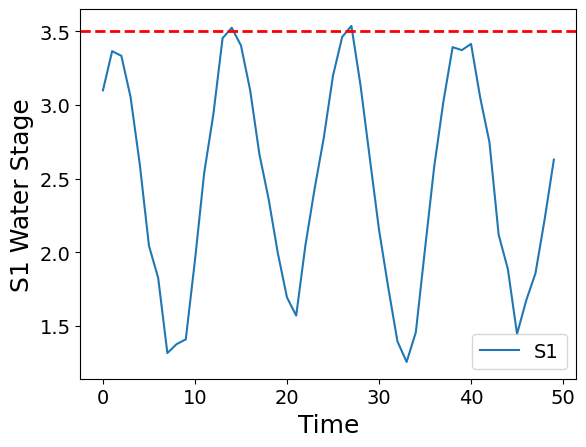

In [22]:
plt.plot(best_perf[:, 0], label='S1')
plt.axhline(y = 3.5, color='r', linestyle='dashed', linewidth=2)
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [23]:
Optimal_gate = pd.DataFrame(best_gate.reshape(duration, -1) )
Optimal_gate.to_csv("GA_results/best_gate_event7.csv", index=False)
Optimal_gate

0         1         2         3         4         5         6    \
0   0.927632  0.984411  0.217493  0.517367  0.672242  0.391137  0.083387   
1   0.299760  0.902770  0.209447  0.081988  0.651108  0.986208  0.063189   
2   0.050876  0.828110  0.304346  0.399935  0.953161  0.275112  0.922138   
3   0.739859  0.788126  0.919102  0.017132  0.416707  0.395781  0.797675   
4   0.637037  0.984372  0.227685  0.161147  0.392445  0.494352  0.840592   
5   0.692307  0.266895  0.341696  0.699903  0.311116  0.897352  0.899213   
6   0.129804  0.311999  0.655046  0.122062  0.340690  0.234542  0.051583   
7   0.068361  0.489690  0.573755  0.845873  0.520609  0.540791  0.148284   
8   0.132327  0.698845  0.177991  0.683594  0.006467  0.839384  0.919890   
9   0.859999  0.408590  0.614743  0.604472  0.917634  0.284530  0.318387   
10  0.166597  0.113740  0.535072  0.100539  0.513646  0.112400  0.413127   
11  0.587155  0.553050  0.774951  0.874792  0.562872  0.770442  0.925021   
12  0.776918  0.794626  0.761365  0.460183  0.053442  0.620475  0.344485   
13  0.713391  0.692087  0.495615  0.430459  0.028847  0.508924  0.095323   
14  0.549805  0.945341  0.555047  0.418914  0.086112  0.547833  0.971707   
15  0.212867  0.765668  0.373055  0.685675  0.976949  0.119542  0.494248   
16  0.096147  0.747125  0.228659  0.317993  0.370673  0.341553  0.777322   
17  0.292735  0.170321  0.464395  0.536744  0.102495  0.058161  0.374980   
18  0.626132  0.694574  0.526961  0.051929  0.809852  0.247608  0.882989   
19  0.640393  0.006421  0.481625  0.839493  0.681609  0.810938  0.901114   
20  0.963943  0.517373  0.784893  0.013037  0.518178  0.027586  0.274080   
21  0.110929  0.904977  0.675485  0.312422  0.502073  0.320365  0.561920   
22  0.131089  0.039444  0.967927  0.971106  0.611846  0.663105  0.521093   
23  0.781898  0.746482  0.699329  0.305557  0.505690  0.906797  0.164998   
24  0.742187  0.366772  0.729762  0.603697  0.420151  0.524462  0.139584   
25  0.055070  0.993861  0.064963  0.126593  0.837955  0.357911  0.174442   
26  0.034884  0.186114  0.420047  0.944556  0.803448  0.629371  0.015330   
27  0.930386  0.593300  0.614341  0.343988  0.735096  0.952486  0.109462   
28  0.594999  0.988354  0.458171  0.043616  0.544726  0.110672  0.191034   
29  0.992043  0.943726  0.062976  0.682206  0.566142  0.808710  0.669611   
30  0.467219  0.979322  0.656802  0.551136  0.373986  0.058824  0.674103   
31  0.212432  0.768794  0.261021  0.646283  0.881821  0.487093  0.466161   
32  0.838128  0.658929  0.064511  0.177343  0.110795  0.763490  0.151485   
33  0.969283  0.021619  0.838572  0.282286  0.047734  0.545069  0.891765   
34  0.261526  0.889838  0.139249  0.618056  0.093043  0.064985  0.570556   
35  0.613036  0.319060  0.236184  0.130960  0.406935  0.656010  0.900515   
36  0.543845  0.039284  0.840605  0.133930  0.218411  0.072389  0.594103   
37  0.089958  0.196130  0.622179  0.461311  0.014933  0.339832  0.721930   
38  0.726786  0.618748  0.475878  0.296443  0.220649  0.240187  0.012259   
39  0.547577  0.336214  0.778937  0.411177  0.333740  0.507652  0.703341   
40  0.221063  0.632589  0.065917  0.065968  0.866459  0.990389  0.560045   
41  0.898499  0.096225  0.275929  0.685660  0.155361  0.603330  0.550514   
42  0.656965  0.957034  0.137778  0.269636  0.479480  0.576715  0.267559   
43  0.838526  0.923394  0.142532  0.968160  0.030971  0.018659  0.539763   
44  0.624919  0.528428  0.741458  0.991086  0.477752  0.247200  0.382284   
45  0.790416  0.412741  0.056160  0.045830  0.716258  0.808530  0.165273   
46  0.100341  0.080133  0.406082  0.485263  0.100531  0.773526  0.773692   
47  0.258451  0.302231  0.881052  0.721372  0.373619  0.881726  0.500749   
48  0.699675  0.193179  0.318333  0.434748  0.195505  0.774226  0.848663   
49  0.648557  0.342812  0.450431  0.530212  0.465762  0.462041  0.370717   

         7         8         9    ...       662       663       664       665  \
0   0.142736  0.217439  0.151871  ...  0.321047  0.

In [24]:
Optimal_case = pd.DataFrame(best_perf)
Optimal_case.to_csv("GA_results/best_performance_event7.csv", index=False)
Optimal_case

0         1         2         3         4         5         6   \
0   3.099939  2.799720  3.057810  3.073906  3.428599  3.200196  3.301611   
1   3.365659  3.262462  3.398757  3.376330  3.317459  3.133437  3.267599   
2   3.334057  3.093636  3.371087  3.402928  3.131289  3.310549  3.211969   
3   3.054852  3.094692  3.133476  3.125329  2.691401  2.505972  2.711858   
4   2.599159  2.513879  2.694385  2.608819  2.312657  2.037675  2.393093   
5   2.045330  2.132721  2.031883  2.010914  1.746381  1.475444  1.773157   
6   1.827396  1.843301  2.014801  1.886850  1.416317  1.352436  1.540936   
7   1.317007  1.278230  1.389519  1.230167  1.401533  1.066828  1.426697   
8   1.377400  1.535537  1.410325  1.234870  1.579540  1.349824  1.578299   
9   1.409892  1.292059  1.493385  1.406932  1.959367  1.965155  1.978046   
10  1.947100  1.699746  1.994189  2.020693  2.444811  2.321743  2.293948   
11  2.539241  2.828196  2.595701  2.706713  2.969162  3.019787  2.892305   
12  2.938161  2.999624  2.924847  2.870859  3.364738  3.356796  3.343289   
13  3.453640  3.490435  3.460887  3.478994  3.608152  3.305628  3.603966   
14  3.524482  3.476197  3.554406  3.557111  3.332636  3.420394  3.265486   
15  3.403971  3.407956  3.508699  3.424447  3.070952  3.062150  3.103931   
16  3.099489  3.145840  3.094741  3.008310  2.708474  2.449156  2.650686   
17  2.666950  2.803366  2.729510  2.702926  2.320188  2.114690  2.298687   
18  2.363699  2.210933  2.400987  2.354817  1.986735  2.200328  2.067692   
19  1.996378  1.965163  2.088561  2.047484  1.690149  1.766422  1.749617   
20  1.694239  1.616160  1.681070  1.619151  1.661166  1.493711  1.626691   
21  1.571575  1.477649  1.565994  1.483037  2.001304  2.154090  1.969498   
22  2.047594  2.097888  1.993169  1.992128  2.441441  2.201533  2.360567   
23  2.431702  2.306173  2.415721  2.405475  2.814075  2.667975  2.771657   
24  2.778423  2.691554  2.790921  2.779494  3.253407  2.914291  3.178092   
25  3.199815  3.093997  3.231582  3.297022  3.374999  3.346266  3.376023   
26  3.462649  3.580817  3.494425  3.425508  3.502578  3.296752  3.513396   
27  3.537033  3.610952  3.693822  3.642658  3.124078  2.853666  3.228474   
28  3.129337  3.151012  3.221940  3.204111  2.798635  2.720845  2.896167   
29  2.638548  2.925733  2.761309  2.741455  2.170033  2.204571  2.255707   
30  2.154371  1.880338  2.174154  2.151588  1.897190  1.597742  1.960456   
31  1.762857  2.058416  1.898261  1.769039  1.600437  1.700210  1.751211   
32  1.396841  1.247198  1.476290  1.333087  1.461552  1.553908  1.545386   
33  1.256877  1.462605  1.445662  1.364725  1.608312  1.315124  1.699257   
34  1.458081  1.337094  1.520330  1.440855  2.032652  1.896438  2.027337   
35  2.024624  2.158490  2.168909  2.089639  2.576057  2.425477  2.591550   
36  2.583198  2.500719  2.650140  2.679420  3.005617  2.963937  2.936831   
37  3.024620  3.022843  3.132736  3.118411  3.323996  3.207857  3.281948   
38  3.393130  3.320972  3.506183  3.535250  3.622195  3.590628  3.622159   
39  3.372800  3.305639  3.499022  3.500177  3.460567  3.400426  3.502481   
40  3.415168  3.287476  3.515379  3.493190  3.151836  2.969368  3.260222   
41  3.049121  2.901910  3.106494  3.040026  2.714754  2.737246  2.683151   
42  2.747722  2.636270  2.813107  2.766727  2.113663  1.939764  2.229550   
43  2.120268  2.246244  2.170925  2.230272  1.847595  2.059498  1.863613   
44  1.887370  2.084618  2.007802  1.900363  1.706733  1.693679  1.879448   
45  1.446455  1.607004  1.565187  1.422018  1.602433  1.771848  1.649726   
46  1.674829  1.366838  1.827072  1.708112  1.918034  1.794595  2.016979   
47  1.858151  1.845980  2.004480  1.954867  2.360479  2.206033  2.440682   
48  2.224793  2.302623  2.290317  2.376669  2.622460  2.552892  2.642496   
49  2.629761  2.384354  2.728393  2.711540  3.121139  3.048904  3.108625   

          7         8         9   ...        86        87        88        89  \
0   3.370796  3.485480  3.062885  ...  1.690736  1.6

In [25]:
Optimal_case = pd.read_csv("GA_results/best_performance_event7.csv")
Optimal_case

0         1         2         3         4         5         6  \
0   3.099939  2.799720  3.057810  3.073906  3.428599  3.200196  3.301611   
1   3.365660  3.262462  3.398757  3.376330  3.317459  3.133437  3.267599   
2   3.334057  3.093636  3.371087  3.402928  3.131289  3.310550  3.211969   
3   3.054852  3.094692  3.133475  3.125329  2.691400  2.505972  2.711858   
4   2.599159  2.513879  2.694385  2.608819  2.312657  2.037675  2.393093   
5   2.045330  2.132721  2.031883  2.010914  1.746381  1.475444  1.773157   
6   1.827396  1.843301  2.014801  1.886850  1.416316  1.352436  1.540936   
7   1.317007  1.278230  1.389519  1.230167  1.401533  1.066828  1.426697   
8   1.377400  1.535537  1.410325  1.234870  1.579540  1.349824  1.578299   
9   1.409892  1.292059  1.493385  1.406932  1.959367  1.965155  1.978046   
10  1.947100  1.699746  1.994189  2.020693  2.444811  2.321743  2.293948   
11  2.539241  2.828196  2.595702  2.706713  2.969162  3.019787  2.892305   
12  2.938161  2.999624  2.924847  2.870859  3.364737  3.356796  3.343289   
13  3.453640  3.490435  3.460887  3.478994  3.608152  3.305628  3.603966   
14  3.524482  3.476197  3.554406  3.557111  3.332636  3.420394  3.265486   
15  3.403971  3.407956  3.508699  3.424447  3.070952  3.062150  3.103931   
16  3.099489  3.145840  3.094741  3.008310  2.708474  2.449156  2.650686   
17  2.666950  2.803366  2.729510  2.702926  2.320188  2.114690  2.298687   
18  2.363699  2.210933  2.400987  2.354817  1.986735  2.200328  2.067692   
19  1.996378  1.965163  2.088561  2.047484  1.690149  1.766422  1.749617   
20  1.694239  1.616160  1.681070  1.619151  1.661166  1.493711  1.626691   
21  1.571575  1.477649  1.565994  1.483037  2.001304  2.154090  1.969498   
22  2.047594  2.097888  1.993169  1.992128  2.441441  2.201533  2.360567   
23  2.431702  2.306173  2.415721  2.405475  2.814074  2.667975  2.771657   
24  2.778423  2.691554  2.790921  2.779494  3.253407  2.914291  3.178091   
25  3.199815  3.093997  3.231582  3.297022  3.374999  3.346266  3.376023   
26  3.462649  3.580817  3.494425  3.425508  3.502578  3.296752  3.513396   
27  3.537033  3.610952  3.693822  3.642658  3.124078  2.853666  3.228474   
28  3.129337  3.151012  3.221940  3.204111  2.798635  2.720845  2.896167   
29  2.638548  2.925733  2.761309  2.741455  2.170033  2.204572  2.255707   
30  2.154371  1.880338  2.174154  2.151588  1.897190  1.597742  1.960457   
31  1.762857  2.058416  1.898261  1.769039  1.600437  1.700210  1.751211   
32  1.396841  1.247198  1.476290  1.333087  1.461552  1.553908  1.545386   
33  1.256877  1.462605  1.445662  1.364726  1.608313  1.315124  1.699257   
34  1.458081  1.337094  1.520330  1.440855  2.032652  1.896438  2.027337   
35  2.024624  2.158490  2.168909  2.089639  2.576057  2.425477  2.591550   
36  2.583198  2.500719  2.650140  2.679419  3.005617  2.963937  2.936831   
37  3.024620  3.022843  3.132736  3.118411  3.323996  3.207857  3.281948   
38  3.393130  3.320972  3.506183  3.535250  3.622195  3.590628  3.622159   
39  3.372800  3.305639  3.499022  3.500177  3.460567  3.400426  3.502481   
40  3.415168  3.287476  3.515379  3.493190  3.151836  2.969368  3.260222   
41  3.049121  2.901910  3.106494  3.040026  2.714754  2.737246  2.683152   
42  2.747722  2.636270  2.813107  2.766727  2.113663  1.939764  2.229550   
43  2.120268  2.246244  2.170925  2.230272  1.847595  2.059498  1.863613   
44  1.887370  2.084618  2.007802  1.900363  1.706733  1.693679  1.879448   
45  1.446455  1.607004  1.565187  1.422018  1.602433  1.771848  1.649726   
46  1.674829  1.366838  1.827072  1.708112  1.918034  1.794595  2.016980   
47  1.858151  1.845980  2.004480  1.954867  2.360479  2.206033  2.440682   
48  2.224793  2.302623  2.290317  2.376669  2.622460  2.552892  2.642496   
49  2.629761  2.384354  2.728393  2.711540  3.121139  3.048904  3.108625   

           7         8         9  ...        86        87        88        89  \
0   3.370796  3.485480  3.062885  ...  1.690736  1.69

In [26]:
upper_threshold = 3.5
lower_threshold = 0

Optimal_case_reshape = Optimal_case.to_numpy().reshape((-1, 24, 4))

flood_threshold(Optimal_case_reshape, upper_threshold)
drought_threshold(Optimal_case_reshape, lower_threshold)


time steps: 324, areas: 30.51367750000003
time steps: 0, areas: 0


In [27]:
true_ws = saved_model.predict([test_cov[start_idx:end_idx], test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
true_ws = ws_scaler.inverse_transform(true_ws)

true_ws = true_ws.reshape((-1, 24, 4))
flood_threshold(true_ws, upper_threshold)
drought_threshold(true_ws, lower_threshold)

2/2 [==============================] - 0s 4ms/step
time steps: 390, areas: 33.73590064048767
time steps: 0, areas: 0
